<a href="https://colab.research.google.com/github/ccollado7/proyecto_vocales/blob/main/k_means_vocales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Modulos

In [9]:
#Generales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import io
import glob
from pathlib import Path

#Audio
import librosa
from librosa import lpc
from scipy import signal
from scipy.signal import find_peaks
#!pip install praat-parselmouth
from parselmouth import praat
import parselmouth 

#No Supervisados
from sklearn.cluster import KMeans
from sklearn import svm

#Supervisados
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 2. Lectura de datos - Dataframe

Leer archivos y armar el dataset

In [ ]:
#url = 'https://raw.githubusercontent.com/ccollado7/proyecto_vocales/main/data/raw/features_'

In [ ]:
#vocales=['A','E','I','O','U']

#df=pd.DataFrame()                     
#for vocal in vocales:
#    df1=pd.read_csv(url+vocal+'.csv',header=None)
#    df1['target']=vocal
#    df=pd.concat([df, df1], axis=0).reset_index(drop=True)

In [3]:
!git clone https://github.com/ccollado7/proyecto_vocales

Cloning into 'proyecto_vocales'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 126 (delta 19), reused 111 (delta 14), pack-reused 4
Receiving objects: 100% (126/126), 1.16 MiB | 12.24 MiB/s, done.
Resolving deltas: 100% (19/19), done.


**Función de extracción de formantes**

Si bien los audios con vocales son señales temporales, se aproximan por sus formates del espectro.

`(https://www.fceia.unr.edu.ar/prodivoz/home_index.html)` | [Prodivoz](https://www.fceia.unr.edu.ar/prodivoz/home_index.html)

In [7]:
def extract_formants(file_path):   
    #version en python de código original de Gonzalo Sad de la materia Prodivoz 
    x, Fs = librosa.load(file_path,sr=None)
    x=x*.95/np.max(np.abs(x))  #se normaliza sx a 95%
    N=4096*8                   #frecuencias en fft
    P=12                       #coeficientes lpc
    #window = np.hamming(len(x))
    #x1 = x * window
    #y=np.abs(np.fft.fft(x1))
    #f=np.arange(0,Fs/2-Fs/N,Fs/N)
    #omega=2*np.pi*f               #frecuencia angular
    A = lpc(x, P)
    B=[1]
    B=np.append(B,np.zeros(P)) #[1 y p ceros]
    
    s1 = signal.TransferFunction(B, A,dt=1/Fs)
    w,mag, phase = signal.dbode(s1,n=2000)
    
    peaks, nn = find_peaks(mag)
    fmaximos=w[peaks]/(2*np.pi)
    if (fmaximos[0]>200):
        formant_freq=np.array([fmaximos[0], fmaximos[1]])
    else:
        formant_freq=np.array([fmaximos[1], fmaximos[2]])
    
    return pd.DataFrame(formant_freq).transpose()

In [10]:
df=pd.DataFrame()
for file_path in glob.glob('proyecto_vocales/data/raw/wav/*.wav'):
    filename = Path(file_path).stem
    filename_parts = filename.split('_')
    metadata = {'file_path': file_path,
              'vocal': filename_parts[0],
              'id': filename_parts[1]}
    df1=extract_formants(file_path)
    df1['target']=filename_parts[0]
    df=pd.concat([df, df1], axis=0).reset_index(drop=True)

df['target']=df['target'].str.upper()
df.sort_values(by=['target'], ascending=True,inplace=True)

In [ ]:
df.head()

,0,1,target
39,1002.0,1550.0,A
40,948.0,1506.0,A
2,780.0,1214.0,A
4,766.0,1234.0,A
53,810.0,1250.0,A


In [ ]:
df.columns

Index([0, 1, 'target'], dtype='object')

**Alternativa para extraer formantes Praat**

`(https://parselmouth.readthedocs.io/en/stable/)` | [Parselmouth](https://parselmouth.readthedocs.io/en/stable/) 


In [ ]:
def extract_praat(file_path):
    sound = parselmouth.Sound(file_path)
    formants = praat.call(sound, "To Formant (burg)", 0.025, 5, 8000, 0.05, 50)# 5 formantes recomendado
    f1_list = []
    f2_list = []
    f_mean=[]
    #f3_list = []
    for i in range(2, formants.get_number_of_frames()+1):
        f1 = formants.get_value_at_time(1, formants.get_time_step()*i)
        f2 = formants.get_value_at_time(2, formants.get_time_step()*i)
        f3 = formants.get_value_at_time(3, formants.get_time_step()*i)
        f1_list.append(f1)
        f2_list.append(f2)
        #f3_list.append(f3)
    f_mean.append(np.mean(f1_list))
    f_mean.append(np.mean(f2_list))
    #f_mean.append(np.median(f3_list))
    return pd.DataFrame(f_mean).transpose()

In [ ]:
df=pd.DataFrame()
for file_path in glob.glob('proyecto_vocales/data/raw/wav/*.wav'):
    filename = Path(file_path).stem
    filename_parts = filename.split('_')
    metadata = {'file_path': file_path,
              'vocal': filename_parts[0],
              'id': filename_parts[1]}
    df1=extract_praat(file_path)
    df1['target']=filename_parts[0]
    df=pd.concat([df, df1], axis=0).reset_index(drop=True)

df['target']=df['target'].str.upper()
df.sort_values(by=['target'], ascending=True,inplace=True)

## 3. Analisis Exploratorio

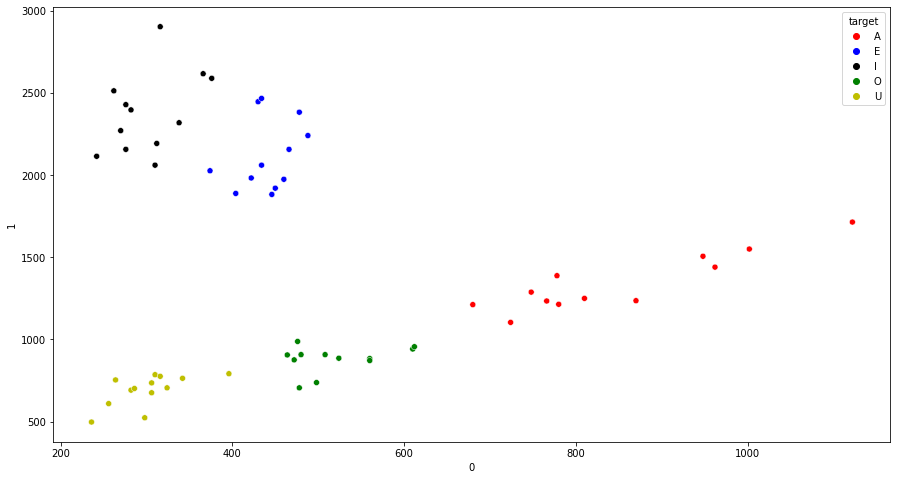

In [11]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=0,y=1,hue='target',palette={'A':'r','E':'b','I':'k','O':'g','U':'y'},data=df,legend='brief')

### 3.1 Atributo 0

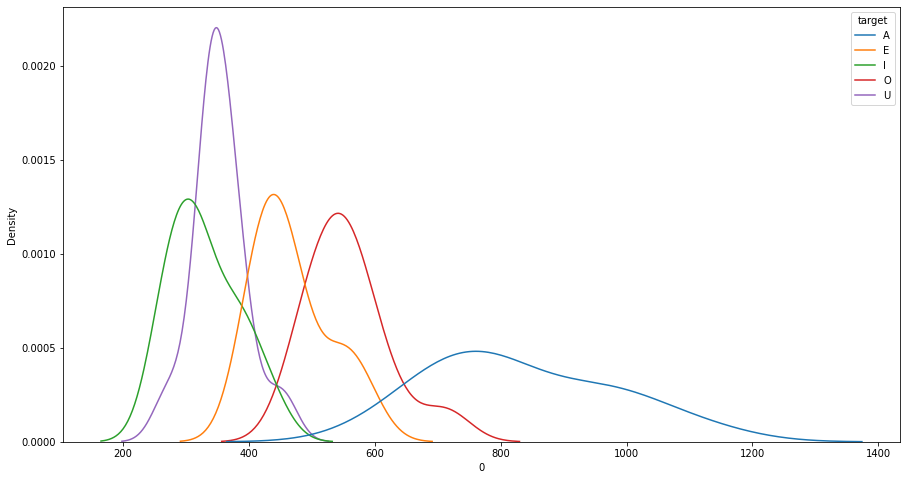

In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x=0, hue="target")

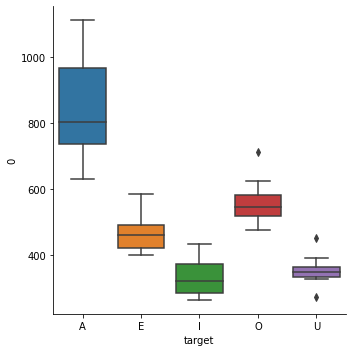

In [ ]:
sns.catplot(x="target", y=0, kind="box", data=df)

### 3.2 Atributo 2

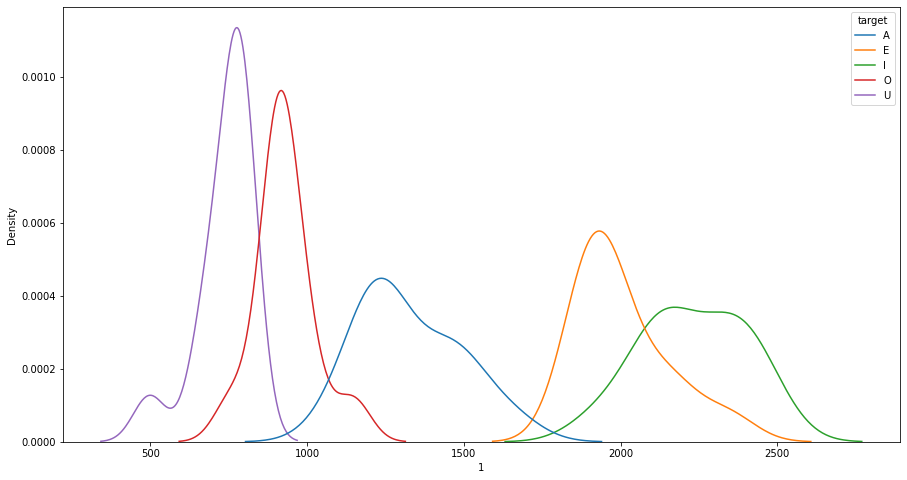

In [ ]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x=1, hue="target")

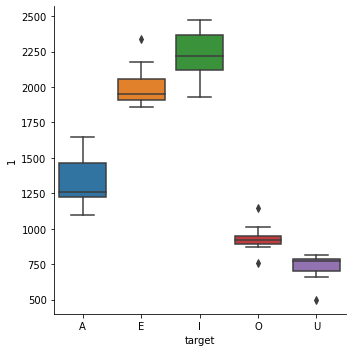

In [ ]:
sns.catplot(x="target", y=1, kind="box", data=df)

### 3.3 Target

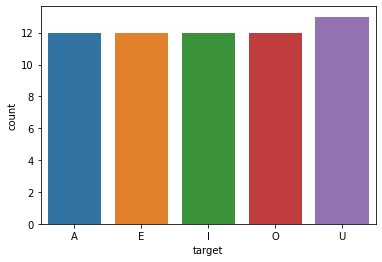

In [ ]:
sns.countplot(x="target", data=df)

## 4. Metodos No Supervisados

### 4.1 Método kmeans

In [ ]:
X=df[[0,1]]
X.head()

,0,1
39,985.139373,1476.144186
40,973.506985,1497.674672
2,781.945406,1211.290869
4,757.792434,1225.030045
53,821.745556,1252.033344


In [ ]:
y=df[['target']]
y.head()

,target
0,O
1,U
2,A
3,E
4,A


In [ ]:
kmeans = KMeans(n_clusters=5).fit(X)

In [ ]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[3 3 2 2 2 3 2 2 3 2 2 2 4 1 4 4 4 4 4 1 1 4 4 4 4 1 1 1 1 1 4 1 1 1 1 1 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[ 432.85154395  809.26693404]
 [ 381.50895785 2266.09111107]
 [ 731.43997199 1202.60356887]
 [1008.35930468 1520.87462989]
 [ 419.9838429  1945.6163403 ]]


([], <a list of 0 Text major ticklabel objects>)

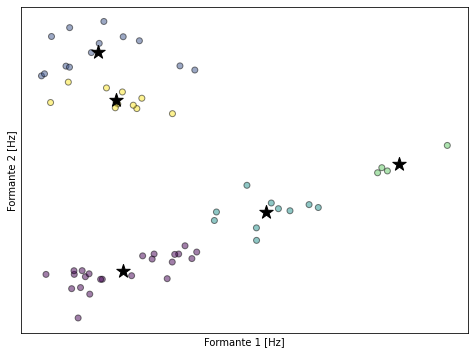

In [ ]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(X[0], X[1],c=kmeans.labels_, alpha=.5, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')
plt.xticks(())
plt.yticks(())

Análisis de clusters

In [ ]:
tmp = pd.DataFrame({'Labels': df.target, 'Clusters': kmeans.labels_})# Create a DataFrame with labels and varieties as columns: df
ct = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct

In [ ]:
print(ct)

Clusters   0   1  2  3  4
Labels                   
A          0   0  8  4  0
E          0   3  0  0  9
I          0  10  0  0  2
O         10   0  2  0  0
U         13   0  0  0  0


In [ ]:
from sklearn.metrics import adjusted_rand_score
ari0 = adjusted_rand_score(df.target, kmeans.labels_)

In [ ]:
print(ari0)

0.524089744750422


De la matriz de confusión surge que las mayores confusiones se dan entre la E y la I.

## 4.2 Método SVM

Primero pruebo con dos vocales para hacer SVM binario. Pruebo con la E e I que aparecen algunas confusines en kmeans

In [ ]:
df2=df.loc[(df['target'] == 'E') | (df['target'] == 'I')]

In [ ]:
X=np.array(df2[[0,1]].values)
y=df2.iloc[:,2:].values.ravel()

C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf.fit(X, y)

SVC(kernel='linear')

Los vectores son

In [ ]:
clf.support_vectors_

array([[ 467.78439863, 2341.83504505],
       [ 282.46258831, 1931.09260711],
       [ 434.00349058, 2368.55248148]])

código para dibujar

In [ ]:
codes = {'E': 0, 'I': 1}

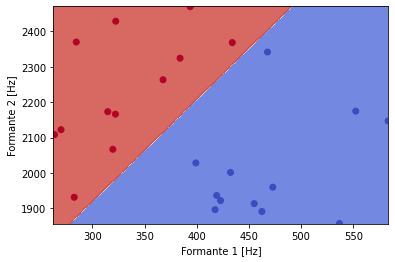

In [ ]:
h = 1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

ZZ=np.array([codes[i] for i in Z])
ZZ=ZZ.reshape(xx.shape)

cat_encoder = LabelEncoder()
ycat=cat_encoder.fit_transform(y)

plt.contourf(xx, yy, ZZ, cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X[:, 0], X[:, 1], c=ycat, cmap=plt.cm.coolwarm)
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

SVM multiclase

In [12]:
X=np.array(df[[0,1]].values)
y=df.iloc[:,2:].values.ravel()

C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='poly',degree=3, C=C) 
clf.fit(X, y)

SVC(kernel='poly')

In [13]:
codes = {'A':0,'E': 1, 'I': 2, 'O':3, 'U':4}

(497.0, 2903.0)

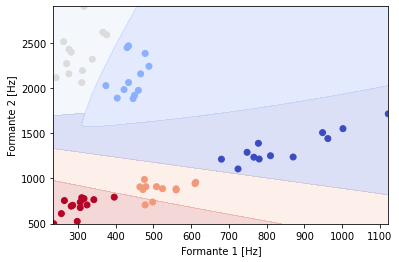

In [14]:
h = 1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

ZZ=np.array([codes[i] for i in Z])
ZZ=ZZ.reshape(xx.shape)

cat_encoder = LabelEncoder()
ycat=cat_encoder.fit_transform(y)

plt.contourf(xx, yy, ZZ, cmap=plt.cm.coolwarm, alpha=0.2)

plt.scatter(X[:, 0], X[:, 1], c=ycat, cmap=plt.cm.coolwarm)
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


## 5. Metodos Supervisados

## 5.1 Separacion train / test

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

In [ ]:
x_train.shape

(45, 2)

In [ ]:
y_train.shape

(45, 1)

In [ ]:
y_train.value_counts()

target
A         9
E         9
I         9
O         9
U         9
dtype: int64

In [ ]:
x_test.shape

(16, 2)

In [ ]:
y_test.shape

(16, 1)

In [ ]:
y_test.value_counts()

target
U         4
A         3
E         3
I         3
O         3
dtype: int64

## 5.2 Estandarizacion features numericos - Encoding del target

Estandarizacion de los features numericos

In [ ]:
num_scaler = StandardScaler()

In [ ]:
x_train = num_scaler.fit_transform(x_train)

In [ ]:
x_test = num_scaler.transform(x_test)

Encoding del target categorico

In [ ]:
cat_encoder = LabelEncoder()

In [ ]:
y_train = cat_encoder.fit_transform(y_train)

C:\Users\ccollado\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
y_test = cat_encoder.transform(y_test)